<a href="https://colab.research.google.com/github/JochiSt/AI_PulseReconstruction/blob/main/TestSTM32_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulse recognition AI

first all the imports

In [605]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Generate template

In [606]:
TOTAL_SAMPLES = 128
RISING_POINTS = 4

def generateTemplate(position = 0, pulse_length = 32, height=1, noise=0, offset=0):

  assert TOTAL_SAMPLES - pulse_length - position - RISING_POINTS * 2 > 0

  # zeroes at front of the pulse
  template = np.zeros(position)

  # create rising edge
  template = np.append(template, np.linspace(0,1,RISING_POINTS, endpoint=False))

  # high part of the pulse
  template = np.append(template, np.ones(pulse_length))

  # create falling edge
  template = np.append(template, np.linspace(1,0,RISING_POINTS, endpoint=False))

  # zeroes after the pulse
  template = np.append(template, np.zeros( TOTAL_SAMPLES - pulse_length - position - 2*RISING_POINTS))

  # multiply by the height to get the right amplitude
  template *= height

  # add some noise
  template  += noise * np.random.randn(*template.shape)

  # add a constant offset
  template += offset

  # clip template to range [0, 255]
  template = np.clip(template, 0, 255)

  # convert to integer
  template = template.astype(int)

  return template

print("template length: ", len(generateTemplate()))

template length:  128


Have a look at the template visually

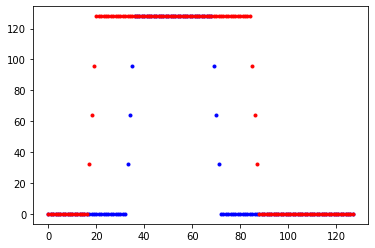

In [607]:
plt.plot(generateTemplate(position = 32, pulse_length=32, height=128), 'b.')
plt.plot(generateTemplate(position = 16, pulse_length=64, height=128), 'r.')
plt.show()

add some noise, and maybe shift the position





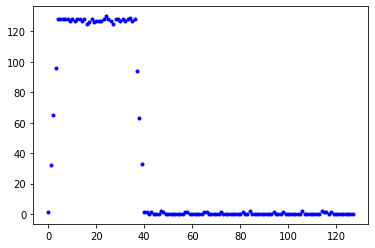

In [608]:
# Plot our data
plt.plot(generateTemplate(height=128, noise=1), 'b.')
plt.show()

## Create Templates for recognision

Generate a couple of templates, which have a pulse in them, and some without any data

20 59 2.3 48
39 24 2.0 118
30 30 2.7 207
41 52 1.7 99
34 45 1.8 54
15 22 2.0 243
0 62 2.8 148
20 41 2.7 237
55 28 1.0 136
17 56 1.5 232


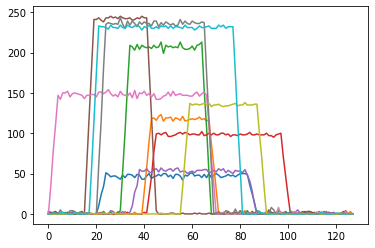

In [609]:
for i in range(10):
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=96-width) # arbitrary position
  noise = np.random.randint(1,30)/10.             # 0.1 to 3 LSB noise
  height = np.random.randint(32,250)              # pulse height of 32 to 128

  print(position, width, noise, height)
  plt.plot(generateTemplate(position = position, pulse_length = width, height=height, noise=noise))

plt.show()

# Building the ANN


### Purpose of the ANN
We want to do Pattern Recognition, based on the waveforms shown above.

The output parameters, which we want to reconstruct are:
*   Width
*   Position
*   height


Starting with importing all things, which we need for creating a model

In [610]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

In [611]:
# number of samples for training, testing etc.
SAMPLES = 100000

## Generate the samples
We want to do Pattern recognition, so we have to link the waveforms to the input parameters.

In [612]:
# scale parameters to get values between 0 and 1
SCALE_WIDTH = 64
SCALE_POS = 32
SCALE_HEIGHT = 255

In [613]:
# parameters for template generation
P_width = (8,64)
P_position = (16,24)
P_height = (32, 255)
P_offset = (0,10)

In [614]:
# use fixed value for noise (1st try)
noise = 1 

y_values = []
x_values = []

# generate the waveforms
for i in range(SAMPLES):
  # use random settings
  width = np.random.randint( *P_width )       # width
  position = np.random.randint( *P_position ) # limit position into a certain window
  height = np.random.randint( *P_height )     # pulse height
  offset = np.random.randint( *P_offset )     # constant offset

  x_values.append( (width/SCALE_WIDTH, position/SCALE_POS, height/SCALE_HEIGHT) )
  y_values.append( generateTemplate(position = position, pulse_length = width, height=height, noise=noise, offset=offset) / SCALE_HEIGHT )

# debug printouts
#print(x_values[:2])
#print(y_values[:2])

### Look at the training data
Just make a 2D histogram of all templates.

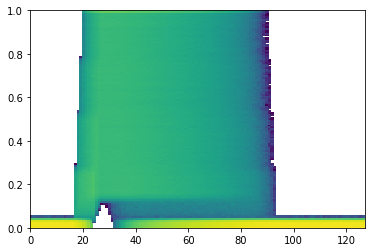

In [615]:
if True:
  plot_x = [ np.arange(128) for i in range(len(y_values)) ]
  plot_x = np.array(plot_x)
  plot_x = plot_x.flatten()
  plot_y = np.array(y_values)
  plot_y = plot_y.flatten()
  plt.hist2d(plot_x, plot_y, bins=128, norm=LogNorm())
  plt.show()

## Split the waveforms into Training, Testing and Validation

In [616]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
print("using %d points for training and %d points for testing"%(TRAIN_SPLIT, TEST_SPLIT))

# convert data into numpy arrays
y_values = np.array(y_values) # parameters
x_values = np.array(x_values) # waveforms

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (len(x_train) + len(x_validate) + len(x_test) ) ==  SAMPLES

using 60000 points for training and 80000 points for testing


## Create the ANN

In [617]:
inputs = keras.Input(shape=(128,), name="waveform_input")

layer_cnt=0
x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001),                       
                       name="layer_%d"%(layer_cnt))(inputs)
layer_cnt+=1

x = keras.layers.Dropout(0.005)(x)

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001),
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dropout(0.005)(x)

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32, 
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt) )(x)
layer_cnt+=1

x = keras.layers.Dense(32,
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(16, 
                       activation='elu',                       
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(16, 
                       activation='elu',                       
                       kernel_regularizer=keras.regularizers.l1(0.00001), 
                       name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

# final layer for classification
outputs = keras.layers.Dense(3, 
                             activation='elu', 
                             name="classification")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs, name="network_v0.3")
model_1.summary()

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "network_v0.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform_input (InputLayer)  [(None, 128)]            0         
                                                                 
 layer_0 (Dense)             (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 layer_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 layer_2 (Dense)             (None, 32)                1056      
                                                                 
 layer_3 (Dense)             (None, 32)               

## Train the model

In [618]:
# Train the model on our training data while validating on our validation set
# remember:
#     y = waveforms
#     x = truth parameters
# just do some trainings to see, whether this structure works or not

#history_1 = model_1.fit(y_train, x_train, epochs=4, batch_size=25, validation_data=(y_validate, x_validate))

In [619]:
# fully train the network
history_1 = model_1.fit(y_train, x_train, epochs=400, batch_size=333, validation_data=(y_validate, x_validate))

# Save the model to disk
#!mkdir -p saved_model
#model_1.save('saved_model/STM32_AI_Test')

Epoch 1/400
181/181 [==============================] - 2s 6ms/step - loss: 0.0263 - accuracy: 0.8153 - val_loss: 0.0145 - val_accuracy: 0.9387
Epoch 2/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0142 - accuracy: 0.9358 - val_loss: 0.0133 - val_accuracy: 0.9506
Epoch 3/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0133 - accuracy: 0.9455 - val_loss: 0.0127 - val_accuracy: 0.9567
Epoch 4/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.9493 - val_loss: 0.0121 - val_accuracy: 0.9513
Epoch 5/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0120 - accuracy: 0.9556 - val_loss: 0.0116 - val_accuracy: 0.9651
Epoch 6/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0116 - accuracy: 0.9591 - val_loss: 0.0112 - val_accuracy: 0.9652
Epoch 7/400
181/181 [==============================] - 1s 5ms/step - loss: 0.0112 - accuracy: 0.9609 - val_loss: 0.0108 - val_accuracy: 0.9729

# Evaluate the training performance

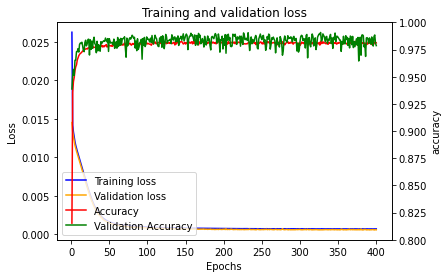

In [620]:
### Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

fig, ax1 = plt.subplots()

p1 = ax1.plot(epochs, train_loss, 'b', label='Training loss')
p2 = ax1.plot(epochs, val_loss, 'orange', label='Validation loss')

ax2 = ax1.twinx()

p3 = ax2.plot(epochs, accuracy, 'r', label='Accuracy')
p4 = ax2.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')

ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('accuracy')
ax2.set_ylim([0.8,1])

lns = p1+p2+p3+p4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower left')

plt.show()

In [621]:
# evaluate the keras model
_, accuracy = model_1.evaluate(y_validate, x_validate)
print('Accuracy: %.2f' % (accuracy*100))

625/625 [==============================] - 2s 2ms/step - loss: 5.8035e-04 - accuracy: 0.9786
Accuracy: 97.86


In [622]:
# Test a couple of waveforms
# remember:
#     y = waveforms
#     x = truth parameters

x_test = x_values[1]
y_test = np.array(generateTemplate(position = int(x_test[0]*SCALE_POS), 
                                   pulse_length = int(x_test[1]*SCALE_WIDTH), 
                                   height=int(x_test[2]*SCALE_HEIGHT), 
                                   noise=0
                                   )/SCALE_HEIGHT)

# waveform needs to be reshaped to be fed into ANN
y_test = y_test.reshape(1,128)

# try, whether we can reconstruct the parameters x_test from the waveform y_test
model_1.make_predict_function()
x_test_pred = np.array(model_1.predict(y_test)[0])

print("sample pulse created: ", x_test)
print("ANN reconstructed:    ", x_test_pred)

sample pulse created:  [0.5625     0.625      0.46666667]
ANN reconstructed:     [0.6221628 0.5639387 0.4696898]


## Have a look at the reconstructed parameters

Get some random pulses, and have a look how they are reconstructed by the network.


In [623]:
# number of test waveforms
TEST_SAMPLES = 10000

In [624]:
waveforms = []        # generated waveforms
orig_parameters = []  # parameters, which are used for the generation
NN_parameters = []    # parameters, reconstructed by the NN

# vary the parameters to have a look a the performance outside the trained 
# parameter boundaries.
parameter_variation = 0.0

# increase the range of parameters in order to see, what is happening
T_width    = ( P_width[0]    * (1 - parameter_variation) , P_width[1]    * (1 + parameter_variation) )
T_position = ( P_position[0] * (1 - parameter_variation) , P_position[1] * (1 + parameter_variation) )
T_height   = ( P_height[0]   * (1 - parameter_variation) , P_height[1]   * (1 + parameter_variation) )
T_offset   = ( P_offset[0]   * (1 - parameter_variation) , P_offset[1]   * (1 + parameter_variation) )

# generate the waveforms
for i in range(TEST_SAMPLES):
  # use random settings
  width = np.random.randint( *T_width )
  position = np.random.randint( *T_position )
  height = np.random.randint( *T_height )
  offset = np.random.randint( *T_offset )

  waveforms.append( np.array(generateTemplate(position = position, pulse_length = width, height=height, noise=noise, offset=offset) / SCALE_HEIGHT ) )
  orig_parameters.append( (width, position, height) )

In [625]:
for i in range(TEST_SAMPLES):
  # waveform needs to be reshaped to be fed into ANN
  waveform = waveforms[i].reshape(1,128)
  width, position, height = model_1.predict(waveform)[0]
  width *= SCALE_WIDTH
  position *= SCALE_POS
  height *= SCALE_HEIGHT

  NN_parameters.append( (width, position, height))


In [634]:
import time
# save results for further plotting
np.savez("colab_eval_%s_noise_%4.3f_%d.npz"%(time.strftime("%Y%m%d_%H%M%S"), noise, TEST_SAMPLES),
             reco_params=NN_parameters,
             gene_params=orig_parameters
             )

Plot the distributions

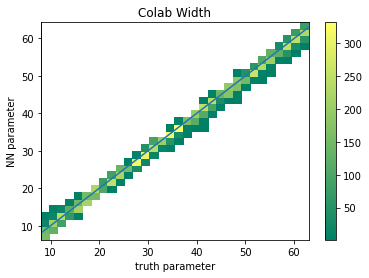

In [627]:
plot_x = [k[0] for k in orig_parameters]
plot_y = [k[0] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_width),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Width")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

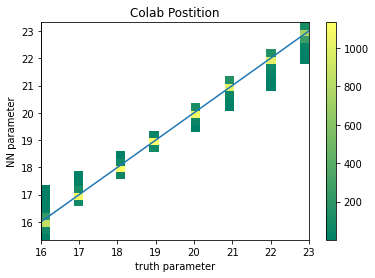

In [628]:
plot_x = [k[1] for k in orig_parameters]
plot_y = [k[1] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_position),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Postition")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

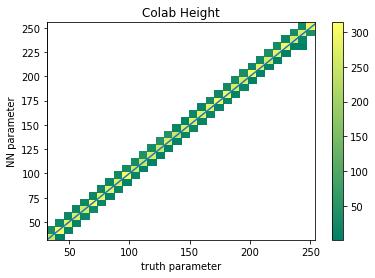

In [629]:
plot_x = [k[2] for k in orig_parameters]
plot_y = [k[2] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, cmin=1, cmap='summer')
plt.vlines(np.array(P_height),ymin=0, ymax=1000)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.colorbar()
plt.title("Colab Height")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

# What happens at zero input?
What if the input array is all zero?

In [630]:
# waveform needs to be reshaped to be fed into ANN
waveform = np.zeros(128)
waveform = waveform.reshape(1,128)
print( model_1.predict(waveform)[0] )

[0.3130495  0.5967831  0.02239061]


# Export to STM32

following:
This [tutorial](https://www.digikey.de/en/maker/projects/tinyml-getting-started-with-stm32-x-cube-ai/f94e1c8bfc1e4b6291d0f672d780d2c0) from DigiKey 

In [631]:
# settings
tflite_model_name = 'pulse_reco'  # Will be given .tflite suffix
c_model_name = 'pulse_reco'       # Will be given .h suffix

In [632]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # option OPTIMIZE_FOR_SIZE is deprecated
tflite_model = converter.convert()

open(tflite_model_name+'.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpsaa8ig1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpsaa8ig1j/assets


17536

For usage inside the [STM32Cube.AI](https://www.st.com/content/st_com/en/support/learning/stm32-education/stm32-moocs/Introduction_to_STM32CubeAI_MOOC.html) it is sufficient to just have the tensorflow light model. The special export seems not be needed.

We have to define a special function, which exports our data into a H-file, which can be later used and included into our microcontroller code.

The function is from https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c

## Test the TFlite model

In [633]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_name+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array( y_test, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0]

print("sample pulse created:    ", x_test)
print("TFlite reconstructed:    ", output_data)

sample pulse created:     [0.5625     0.625      0.46666667]
TFlite reconstructed:     [0.61671185 0.5624044  0.47383475]
